# EEG PROCESSING

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.signal
import mne
import ast

## OBJECTS

In [2]:
signal_1 = pd.read_csv("datos.csv")[['timestamp', 'sample_number', 'channel_data']]
signal_2 = pd.read_csv("datos.csv")[['timestamp', 'sample_number', 'channel_data']]
signal_1.channel_data = signal_1.channel_data.apply(ast.literal_eval)
signal_2.channel_data = signal_2.channel_data.apply(ast.literal_eval)

In [3]:
channel_data_df = signal_1.channel_data.apply(pd.Series) * 2.4 / 12 / (2**23 - 1) # Convert to a millivolts
channel_data_df.columns = ['channel_1', 'channel_2', 'channel_3', 'channel_4', 'channel_5', 'channel_6', 'channel_7', 'channel_8']
columnas_a_eliminar = ['channel_5', 'channel_6', 'channel_7', 'channel_8']
channel_data_df = channel_data_df.drop(columns=columnas_a_eliminar)
channel_data_df.shape

(5500, 4)

In [4]:
signal_1 = pd.concat([signal_1.drop('channel_data', axis=1), channel_data_df], axis=1)
signal_1.timestamp = signal_1.timestamp.apply(lambda x: (x - signal_1.timestamp.iloc[0]) / 10 ** 6)
signal_1.shape

(5500, 6)

In [5]:
channel_data_df = signal_2.channel_data.apply(pd.Series) * 2.4 / 12 / (2**23 - 1) # Convert to a millivolts
channel_data_df.columns = ['channel_1', 'channel_2', 'channel_3', 'channel_4', 'channel_5', 'channel_6', 'channel_7', 'channel_8']
columnas_a_eliminar = ['channel_5', 'channel_6', 'channel_7', 'channel_8']
channel_data_df = channel_data_df.drop(columns=columnas_a_eliminar)
channel_data_df.shape

(5500, 4)

In [6]:
signal_2 = pd.concat([signal_2.drop('channel_data', axis=1), channel_data_df], axis=1)
signal_2.timestamp = signal_2.timestamp.apply(lambda x: (x - signal_2.timestamp.iloc[0]) / 10 ** 6)
signal_2.shape

(5500, 6)

In [7]:
fs = 500. #Fp2 f8 t4 
info_1 = mne.create_info(['Fp2','F8','T4','O2'], 
                       sfreq=fs, ch_types='eeg')
info_1.set_montage('standard_1020')
info_1['description'] = 'Pruebas de EEG'
info_1['device_info'] = {'type':'Frontend', 'model':'AD1298'}
info_1['experimenter'] = 'Eloy'
info_1['line_freq'] = 50.0
info_1['subject_info'] = {'id':1,'last_name':'Yapur','first_name':'Jhoseline',
                        'birthday':(2002, 5, 12),'sex':2,'hand':1}
data_1 = signal_1.loc[:, 'channel_1':'channel_4'].values.T
eeg_raw_1 = mne.io.RawArray(data_1, info_1, verbose=True)

Creating RawArray with float64 data, n_channels=4, n_times=5500
    Range : 0 ... 5499 =      0.000 ...    10.998 secs
Ready.


In [8]:
info_2 = mne.create_info(['Fp2','F8','T4','O2'], 
                         sfreq=fs, ch_types='eeg')
info_2.set_montage('standard_1020')
info_2['description'] = 'Pruebas de EEG'
info_2['device_info'] = {'type':'Frontend', 'model':'AD1298'}
info_2['experimenter'] = 'Eloy'
info_2['line_freq'] = 50.0
info_2['subject_info'] = {'id':1,'last_name':'Yapur','first_name':'Jhoseline',
                        'birthday':(2002, 5, 12),'sex':2,'hand':1}
data_2 = signal_2.loc[:, 'channel_1':'channel_4'].values.T
eeg_raw_2 = mne.io.RawArray(data_2, info_2, verbose=True)

Creating RawArray with float64 data, n_channels=4, n_times=5500
    Range : 0 ... 5499 =      0.000 ...    10.998 secs
Ready.


## FILTERING

In [9]:
x1, t = eeg_raw_1.get_data(return_times=True, units='uV')
x2, t = eeg_raw_2.get_data(return_times=True, units='uV')
x1.shape

(4, 5500)

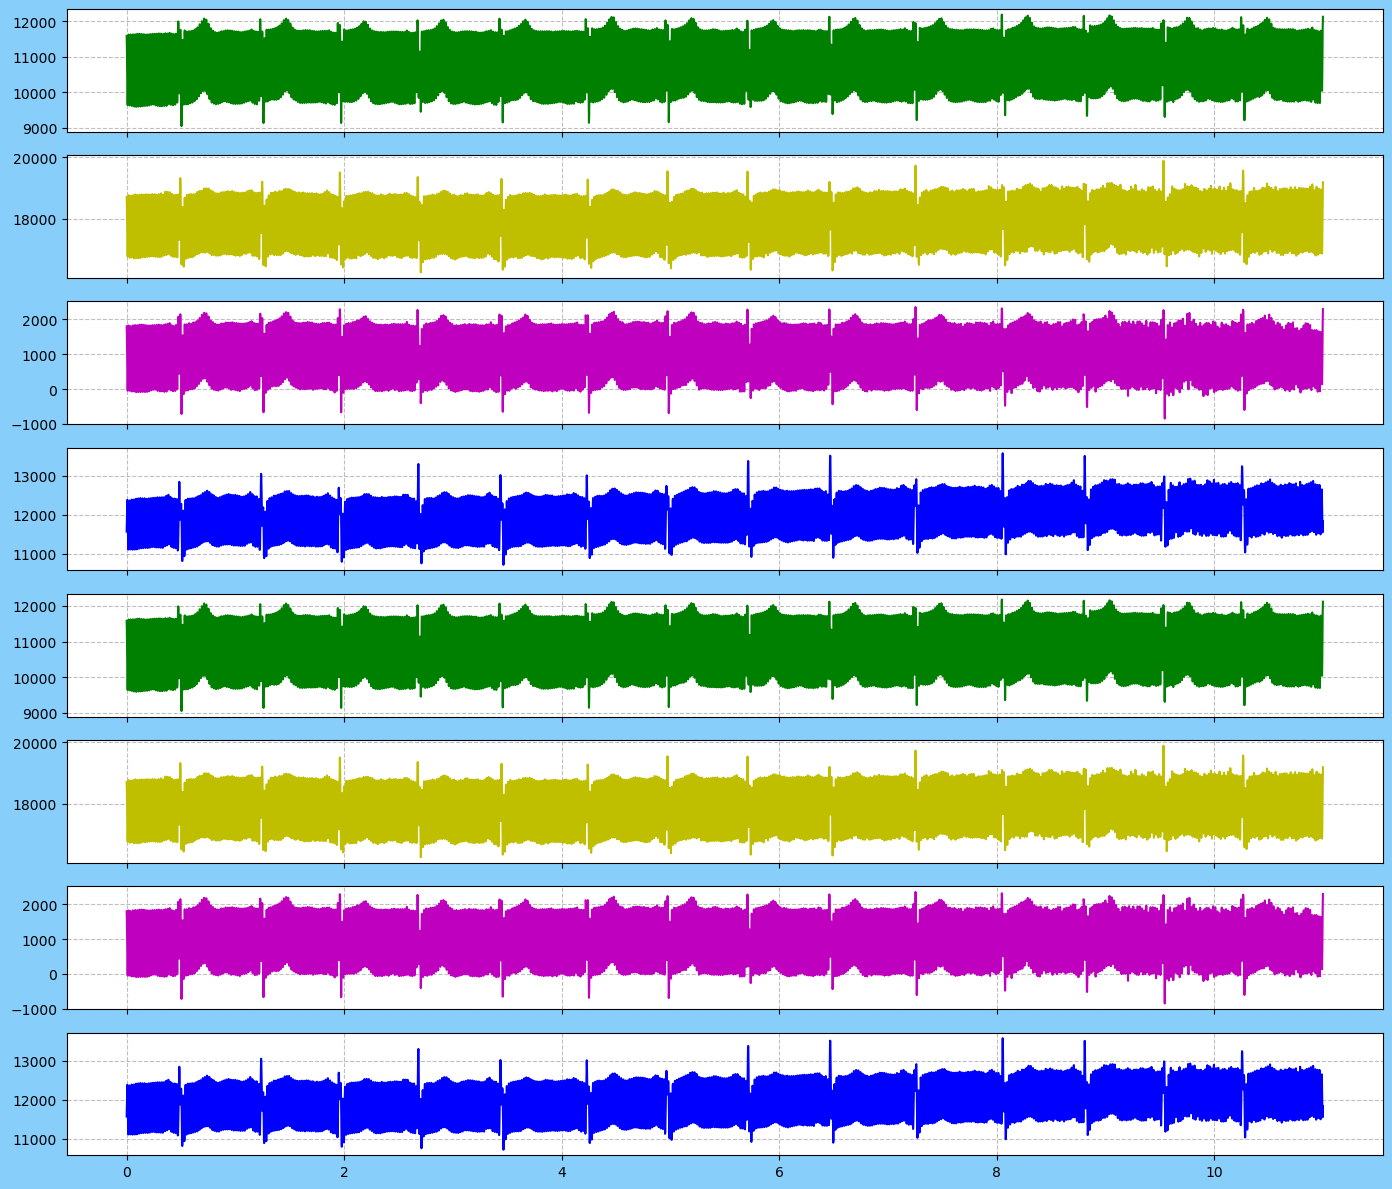

In [10]:
fig, (ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8) = plt.subplots(nrows=8, ncols=1, num=0, figsize=(14, 12), tight_layout=True, sharex=True)
fig.set_facecolor('lightskyblue')

ax1.plot(t, x1[0], lw=1.5, color='g')
ax1.grid(alpha=.8, ls='--')
# ax1.set_xlim(t.min(), t.max() + 1/fs)

ax2.plot(t, x1[1], lw=1.5, color='y')
ax2.grid(alpha=.8, ls='--')

ax3.plot(t, x1[2], lw=1.5, color='m')
ax3.grid(alpha=.8, ls='--')
# ax3.set_ylim(-40, 40)

ax4.plot(t, x1[3], lw=1.5, color='b')
ax4.grid(alpha=.8, ls='--')
# ax4.set_ylim(-30, 30)

ax5.plot(t, x2[0], lw=1.5, color='g')
ax5.grid(alpha=.8, ls='--')
# ax5.set_ylim(-30, 30)

ax6.plot(t, x2[1], lw=1.5, color='y')
ax6.grid(alpha=.8, ls='--')
# ax6.set_ylim(-40, 40)

ax7.plot(t, x2[2], lw=1.5, color='m')
ax7.grid(alpha=.8, ls='--')

ax8.plot(t, x2[3], lw=1.5, color='b')
ax8.grid(alpha=.8, ls='--')

plt.show()

In [29]:
fl, fh = 0.5, 35.
eeg_raw_f_1 = eeg_raw_1.copy().filter(l_freq=fl, h_freq=fh, method='fir', phase='zero', fir_window='hamming', 
                                      fir_design='firwin', pad='reflect', verbose=True)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 35 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 35.00 Hz
- Upper transition bandwidth: 8.75 Hz (-6 dB cutoff frequency: 39.38 Hz)
- Filter length: 3301 samples (6.602 s)



In [42]:
eeg_raw_f_2 = eeg_raw_2.copy().filter(l_freq=fl, h_freq=40, method='fir', phase='zero-double', fir_window='hamming', 
                                      fir_design='firwin', pad='reflect', verbose=True).crop(tmin=0.5, tmax=10.5, include_tmax=False, verbose=True)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-12 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 s)



In [53]:
# Obtener los datos del objeto Raw
x1, t1 = eeg_raw_f_1.get_data(return_times=True, units='uV')
x2, t2 = eeg_raw_f_2.get_data(return_times=True, units='uV')
print(x1.shape)
print(x2.shape)

(4, 5500)
(4, 5000)


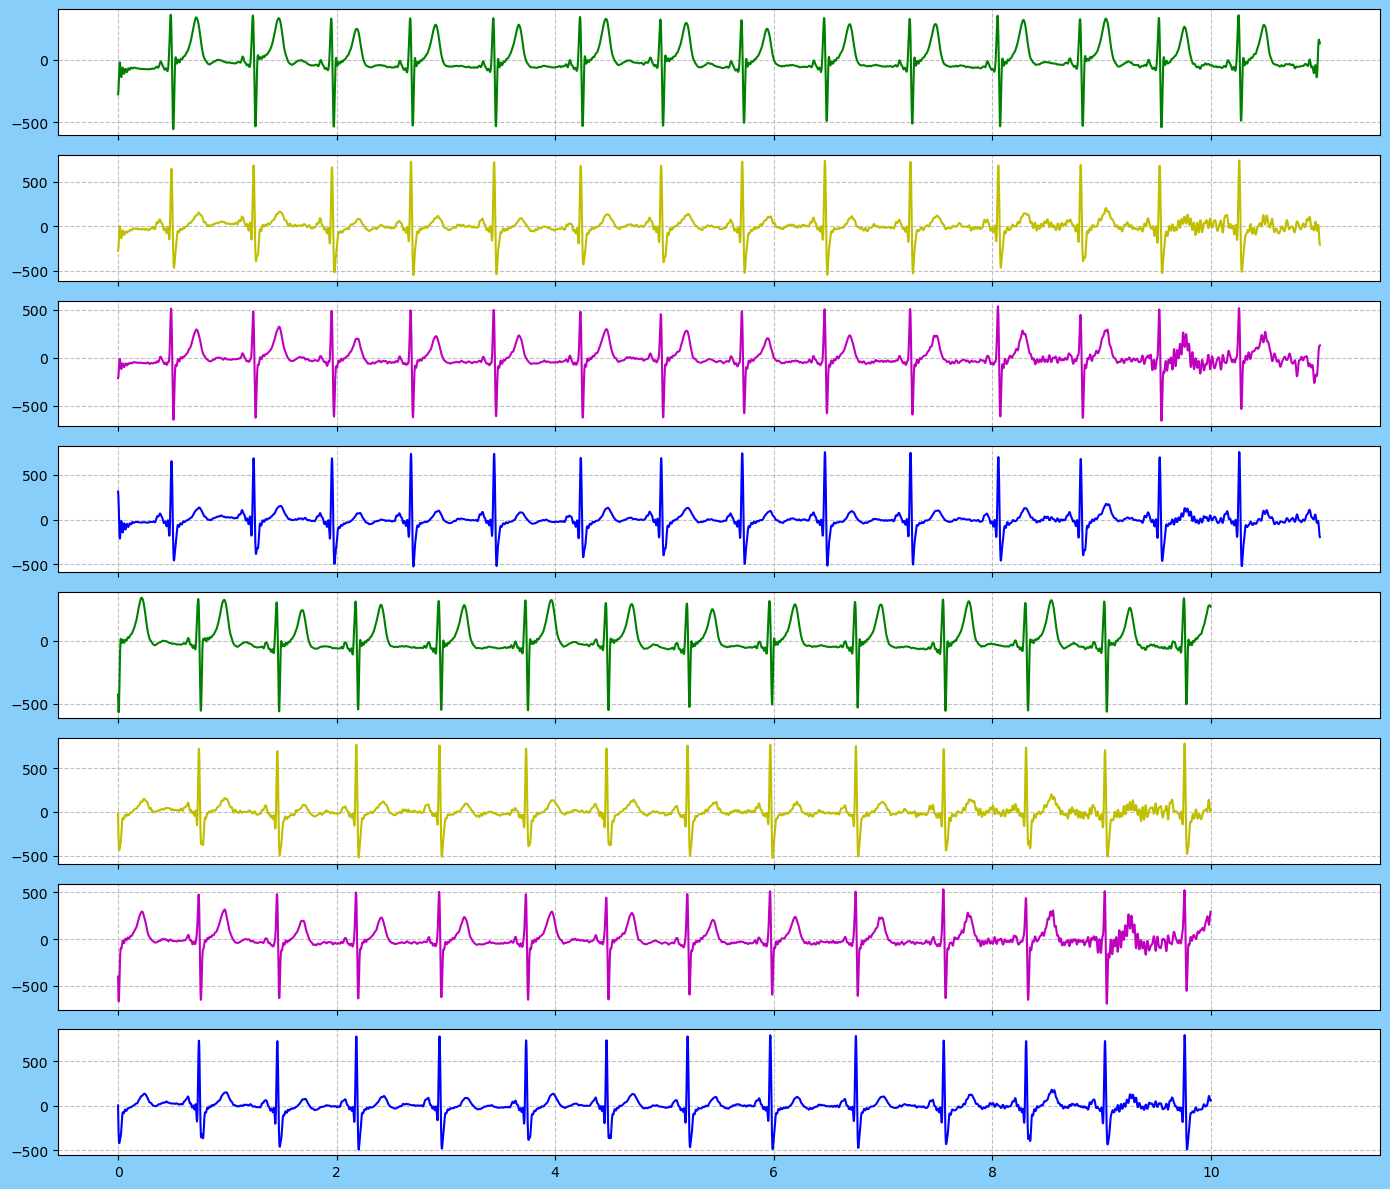

In [44]:
fig, (ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8) = plt.subplots(nrows=8, ncols=1, num=0, figsize=(14, 12), tight_layout=True, sharex=True)
fig.set_facecolor('lightskyblue')

ax1.plot(t1, x1[0], lw=1.5, color='g')
ax1.grid(alpha=.8, ls='--')
# ax1.set_xlim(t.min(), t.max() + 1/fs)
# ax1.set_ylim(-55, 55)

ax2.plot(t1, x1[1], lw=1.5, color='y')
ax2.grid(alpha=.8, ls='--')
# ax2.set_ylim(-55, 55)

ax3.plot(t1, x1[2], lw=1.5, color='m')
ax3.grid(alpha=.8, ls='--')
# ax3.set_ylim(-80, 80)

ax4.plot(t1, x1[3], lw=1.5, color='b')
ax4.grid(alpha=.8, ls='--')
# ax4.set_ylim(-55, 55)

ax5.plot(t2, x2[0], lw=1.5, color='g')
ax5.grid(alpha=.8, ls='--')
# ax5.set_ylim(-55, 55)

ax6.plot(t2, x2[1], lw=1.5, color='y')
ax6.grid(alpha=.8, ls='--')
# ax6.set_ylim(-55, 55)

ax7.plot(t2, x2[2], lw=1.5, color='m')
ax7.grid(alpha=.8, ls='--')

ax8.plot(t2, x2[3], lw=1.5, color='b')
ax8.grid(alpha=.8, ls='--')
# ax8.set_ylim(-40, 40)

plt.show()

## SPECTRAL ANALYSIS

In [89]:
ventana = 4
win = int(ventana * fs)
eeg_PSD_f_1 = eeg_raw_f_1.compute_psd(method='welch', fmax=60.0, picks='data', verbose=True, 
                                      n_fft=win, n_overlap=win // 2, n_per_seg=win, window='hann')

Effective window size : 4.000 (s)


In [90]:
eeg_PSD_f_2 = eeg_raw_f_2.compute_psd(method='welch', fmax=60.0, picks='data', verbose=True, 
                                      n_fft=win, n_overlap=win // 2, n_per_seg=win, window='hann')

Effective window size : 4.000 (s)


Plotting power spectral density (dB=True).
Plotting power spectral density (dB=True).


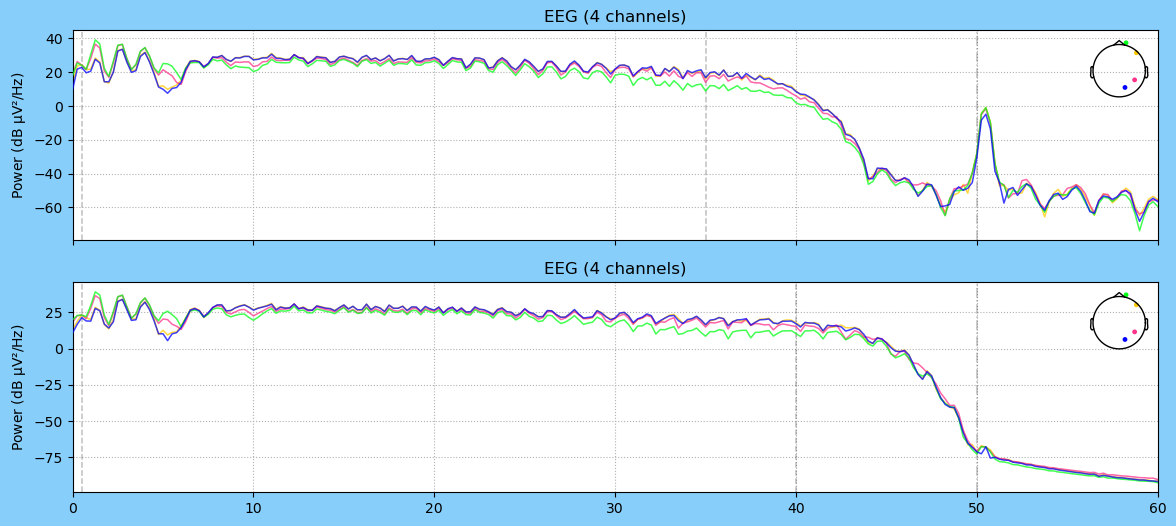

In [91]:
# Crear un objeto Figure y Axes personalizados

fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, num=0, figsize=(14, 6), sharex=True)
fig.set_facecolor('lightskyblue')

# Graficar la PSD en el Axes personalizado
eeg_PSD_f_1.plot(dB=True, amplitude=False, color='r', spatial_colors=True, axes=ax1)
eeg_PSD_f_2.plot(dB=True, amplitude=False, color='b', spatial_colors=True, axes=ax2)

# Personalizar el Axes
for line in ax1.get_lines():
    line.set_linewidth(1.1)  # Aumentar el grosor de las líneas
for line in ax2.get_lines():
    line.set_linewidth(1.1)  # Aumentar el grosor de las líneas
# ax1.set_ylim([-10, 30])  # Cambiar los límites del eje y
# ax2.set_ylim([-10, 30])  # Cambiar los límites del eje y

plt.show()

## TIME-FRECUENCY ANALYSIS

(4, 50, 5000)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)


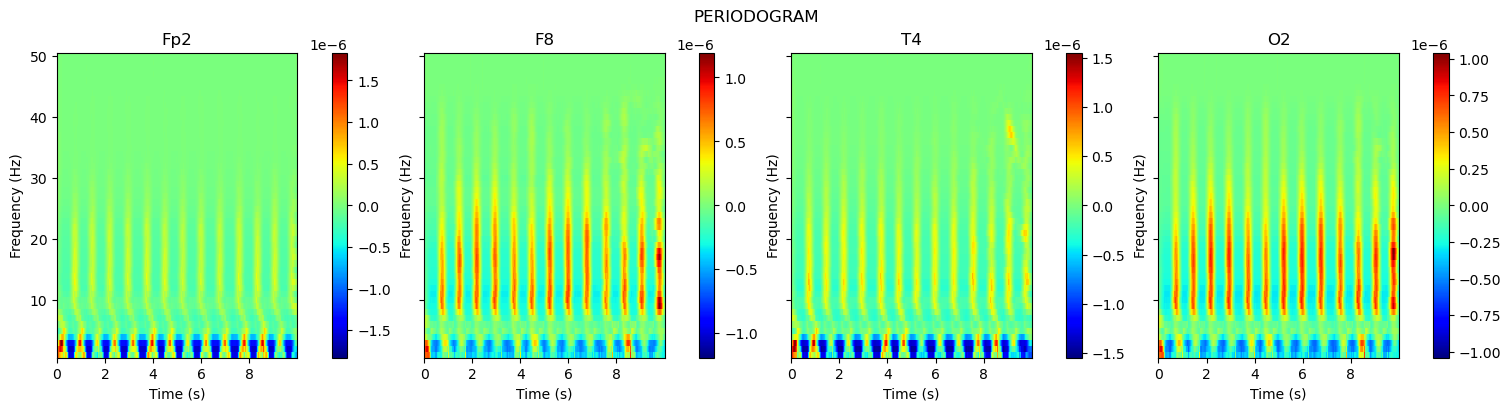

In [206]:
# Definir parámetros para la TFR
freqs = np.arange(1, 51, 1)  # Frecuencias de interés
n_cycles = freqs / 2.  # Número de ciclos por frecuencia
time_bandwidth = 2.0
cmap = plt.cm.YlOrBr 

eeg_TFR_f_2 = eeg_raw_f_2.compute_tfr(method='multitaper', freqs=freqs, picks='data', output='power', verbose=True, 
                                      n_cycles=n_cycles, time_bandwidth=time_bandwidth)
print(eeg_TFR_f_2.shape)
# Visualizar TFR
fig, axs = plt.subplots(1, 4, figsize=(15, 4), sharey=True, layout="constrained")

for i, (ax, title) in enumerate(zip(axs, ['Fp2','F8','T4','O2'])):
    ax.set_title(title)
    eeg_TFR_f_2.plot([i], baseline=(0, 1), mode='mean', cmap='jet', colorbar=True, title="PERIODOGRAM", axes=ax, show=False)

Applying baseline correction (mode: logratio)


[<Figure size 640x480 with 2 Axes>,
 <Figure size 640x480 with 2 Axes>,
 <Figure size 640x480 with 2 Axes>,
 <Figure size 640x480 with 2 Axes>]

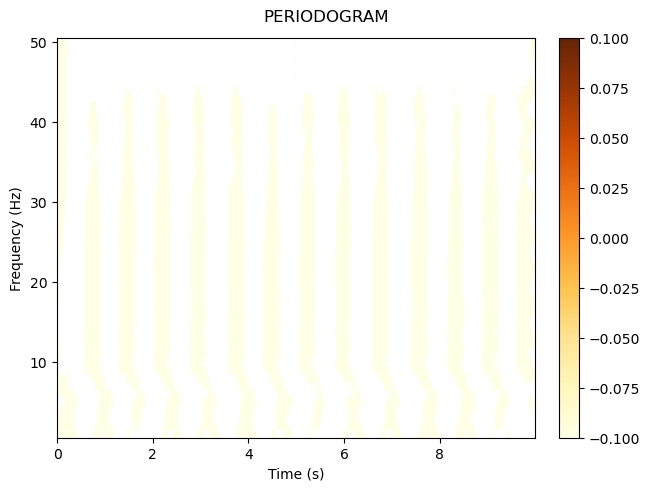

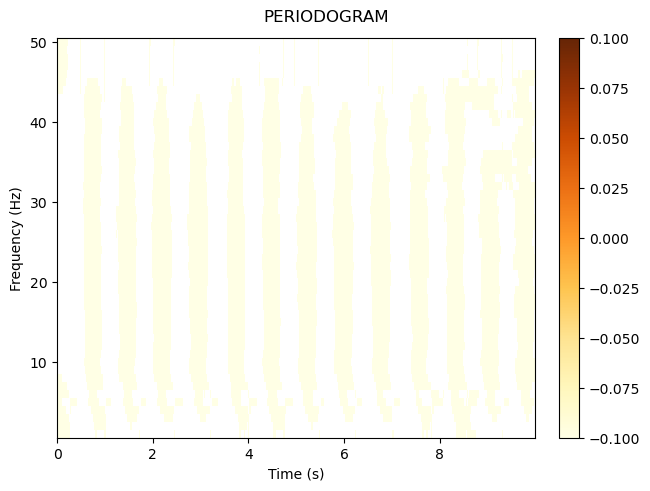

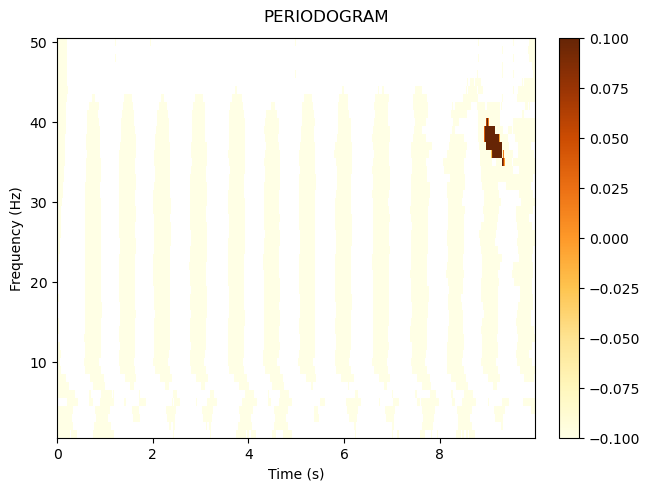

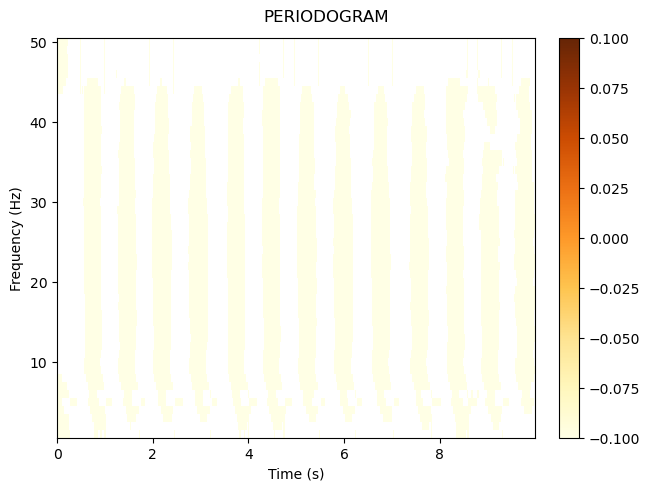

In [180]:
eeg_TFR_f_2.plot(baseline=(0,1), mode='logratio', dB=True, cmap=cmap, colorbar=True, title="PERIODOGRAM", show=False)

In [141]:
freqs

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40])

In [142]:
n_cycles

array([ 0.5,  1. ,  1.5,  2. ,  2.5,  3. ,  3.5,  4. ,  4.5,  5. ,  5.5,
        6. ,  6.5,  7. ,  7.5,  8. ,  8.5,  9. ,  9.5, 10. , 10.5, 11. ,
       11.5, 12. , 12.5, 13. , 13.5, 14. , 14.5, 15. , 15.5, 16. , 16.5,
       17. , 17.5, 18. , 18.5, 19. , 19.5, 20. ])

In [143]:
n_cycles / freqs

array([0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
       0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
       0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
       0.5])

In [ ]:
ventana = 4
win = int(ventana * fs)
eeg_PSD_f_1 = eeg_raw_f_1.compute_psd(method='welch', fmax=60.0, picks='data', verbose=True, 
                                      n_fft=win, n_overlap=win // 2, n_per_seg=win, window='hann')

Text(0, 0.5, 'Frequency [Hz]')

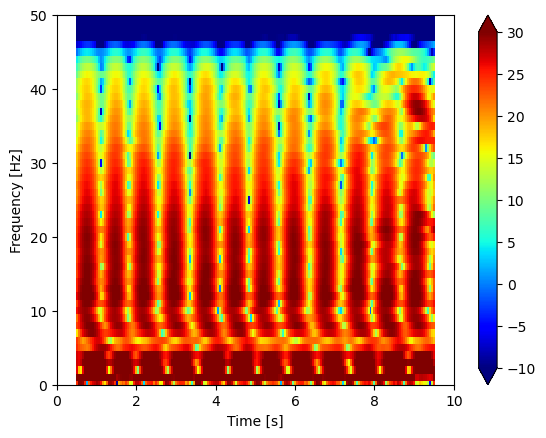

In [267]:
interval = int(fs)        # ... the interval size,
overlap = int(fs * 0.95)  # ... and the overlap intervals

                          # Compute the spectrogram
f, t, Sxx = scipy.signal.spectrogram(
    x2[2],                  # Provide the signal,
    fs=fs,                # ... the sampling frequency,
    window='hann', 
    nperseg=interval,     # ... the length of a segment,
    noverlap=overlap)     # ... the number of samples to overlap,

Sxx = 10 * np.log10(Sxx)

plt.pcolormesh(t, f, Sxx, cmap='jet')# Plot the result
plt.colorbar(extend='both')   # ... with a color bar,
plt.clim(-10, 30);
plt.ylim([0, 50])             # ... set the frequency range,
plt.xlim([0, 10])             # ... set the frequency range,
plt.xlabel('Time [s]')        # ... and label the axes
plt.ylabel('Frequency [Hz]')

Text(0, 0.5, 'Frequency [Hz]')

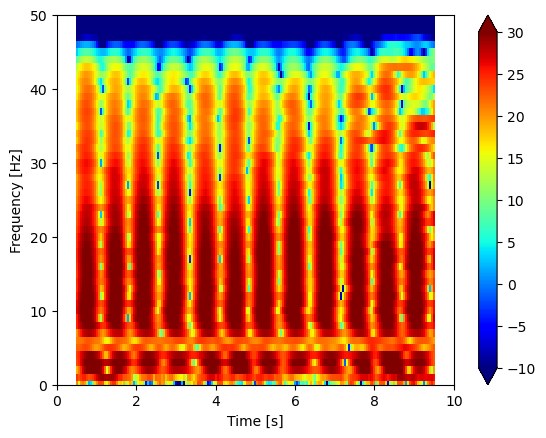

In [265]:
f, t, Sxx = scipy.signal.spectrogram(
    x2[1],                  # Provide the signal,
    fs=fs,                # ... the sampling frequency,
    window='hann', 
    nperseg=interval,     # ... the length of a segment,
    noverlap=overlap)     # ... the number of samples to overlap,

Sxx = 10 * np.log10(Sxx)

plt.pcolormesh(t, f, Sxx, cmap='jet')# Plot the result
plt.colorbar(extend='both')   # ... with a color bar,
plt.clim(-10, 30);
plt.ylim([0, 50])             # ... set the frequency range,
plt.xlim([0, 10])             # ... set the frequency range,
plt.xlabel('Time [s]')        # ... and label the axes
plt.ylabel('Frequency [Hz]')